In [1]:
import tensorflow as tf
import numpy as np

import cv2

import os 
from random import randint, shuffle

import time

In [2]:
from ops import losses
from ops import utils

from tqdm import * 
from datetime import datetime
import matplotlib.pyplot as plt
% matplotlib inline

# Looking up Data

안에 함께 첨부된 Read Me를 보면 txt 파일(Annotation File) 안에 각 사진마다의 정보들이 어떻게 담겨있는지가 있습니다.  

### Read Me 

Format:  
The dataset is divided into two parts: training and testing. The annotations are stored in according text files (training.txt and   testing.txt). Each line in the text file is for one face image. The format is:  
#image path #x1...x5,y1..y5 #gender #smile #wearing glasses #head pose  

--x1...x5,y1...y5: the locations for left eye, right eye, nose, left mouth corner, right mouth corner.  
--gender: 1 for male, 2 for female  
--smile: 1 for smiling, 2 for not smiling  
--glasses: 1 for wearing glasses, 2 for not wearing glasses.  
--head pose: 1 for left profile, 2 for left, 3 for frontal, 4 for right, 5 for right profile  

그럼 여기에서 저희가 원하는 정보는 gender 밖에 없으니 Gender의 정보만 가져오도록 합니다.  
1은 남성, 2는 여성으로 표시 되어있습니다. 

In [3]:
# 각 이미지에 대한 정보들이 담겨있는 txt 파일을 불러왔습니다. 
annot_f = open('data/training.txt', 'r')
annot = annot_f.read()

print(annot[:1000])

lfw_5590\Aaron_Eckhart_0001.jpg 107.250000 147.750000 126.250000 106.250000 140.750000 108.750000 113.250000 143.750000 158.750000 162.750000 1 2 2 3
 lfw_5590\Aaron_Guiel_0001.jpg 101.250000 146.750000 125.250000 93.750000 139.750000 112.250000 117.750000 137.750000 160.750000 164.750000 1 1 2 3
 lfw_5590\Aaron_Peirsol_0001.jpg 107.750000 147.750000 130.250000 109.250000 147.750000 114.250000 114.250000 140.750000 154.250000 153.750000 1 1 2 3
 lfw_5590\Aaron_Pena_0001.jpg 102.750000 146.250000 126.250000 120.750000 147.250000 117.750000 104.750000 137.750000 164.750000 156.750000 1 2 2 3
 lfw_5590\Aaron_Sorkin_0001.jpg 102.250000 144.750000 130.750000 100.250000 143.250000 113.250000 112.750000 138.750000 156.250000 155.750000 1 1 2 3
 lfw_5590\Aaron_Tippin_0001.jpg 104.750000 142.750000 130.250000 111.750000 135.750000 112.750000 112.250000 134.750000 157.250000 156.250000 1 2 2 4
 lfw_5590\Abba_Eban_0001.jpg 106.750000 146.750000 134.750000 108.750000 149.750000 114.750000 111.2500

In [4]:
# 위에 보면 어떠한 묶음이나 다른 처리 없이 모든 정보들이 text로 모여있었는데. 
# txt 안에 내용들을 띄어쓰기(\n)을 기준으로 한 묶음 씩 나누도록 하였습니다. 
annots = annot.split('\n')[:-1] 

annots[:10]

['lfw_5590\\Aaron_Eckhart_0001.jpg 107.250000 147.750000 126.250000 106.250000 140.750000 108.750000 113.250000 143.750000 158.750000 162.750000 1 2 2 3',
 ' lfw_5590\\Aaron_Guiel_0001.jpg 101.250000 146.750000 125.250000 93.750000 139.750000 112.250000 117.750000 137.750000 160.750000 164.750000 1 1 2 3',
 ' lfw_5590\\Aaron_Peirsol_0001.jpg 107.750000 147.750000 130.250000 109.250000 147.750000 114.250000 114.250000 140.750000 154.250000 153.750000 1 1 2 3',
 ' lfw_5590\\Aaron_Pena_0001.jpg 102.750000 146.250000 126.250000 120.750000 147.250000 117.750000 104.750000 137.750000 164.750000 156.750000 1 2 2 3',
 ' lfw_5590\\Aaron_Sorkin_0001.jpg 102.250000 144.750000 130.750000 100.250000 143.250000 113.250000 112.750000 138.750000 156.250000 155.750000 1 1 2 3',
 ' lfw_5590\\Aaron_Tippin_0001.jpg 104.750000 142.750000 130.250000 111.750000 135.750000 112.750000 112.250000 134.750000 157.250000 156.250000 1 2 2 4',
 ' lfw_5590\\Abba_Eban_0001.jpg 106.750000 146.750000 134.750000 108.7500

In [5]:
img_list = []
ann_list = []

for n, i in enumerate(annots):
    info = i.split(' ')

    # 첫 줄에는 빈 공간이 있어 첫줄에만 다음과 같은 컨디션을 주었습니다. 
    if n == 0:
        img_path = info[0]
        img_path = img_path.replace('\\', '/')
        # 맨 앞에 있는 정보에서 이미지의 위치를 뽑았습니다. 
        img_list.append('data/'+img_path)

    else:
        img_path = info[1]
        img_path = img_path.replace('\\', '/')
        img_list.append('data/'+img_path)


    # 끝에서 4번째에 있는 정보가 그 사진의 성별을 나타내기에 one-hot-enocding으로
    # 1면 [0,1], 2이면 [1,0]으로 표현하도록 하였습니다. 
    gender = info[-4]
    if gender == '1':
        ann_list.append([1,0])  # Male
    elif gender == '2':
        ann_list.append([0,1])  # Female

In [6]:
# 위에 코드들을 한번에 함수화 하도록 하겠습니다. 
def extract_list(annot_path):
    annot_f = open(annot_path, 'r')
    annot = annot_f.read()
    annots = annot.split('\n')[:-1]
    img_list = []
    ann_list = []

    for n, i in enumerate(annots):
        info = i.split(' ')

        if n == 0:
            img_path = info[0]
            img_path = img_path.replace('\\', '/')
            img_list.append('data/'+img_path)

        else:
            img_path = info[1]
            img_path = img_path.replace('\\', '/')
            img_list.append('data/'+img_path)


        gender = info[-4]
        if gender == '1':
            ann_list.append([1,0]) 
        elif gender == '2':
            ann_list.append([0,1]) 
            
    return img_list, ann_list

In [7]:
os.listdir('data/')

train_imgs, train_labels = extract_list('data/training.txt')
test_imgs, test_labels = extract_list('data/testing.txt')

In [8]:
print('Train Imgs : ', len(train_imgs))
print('Test Imgs : ', len(test_imgs))

Train Imgs :  10000
Test Imgs :  2995


In [9]:
# 이미지 사이즈들이 워낙 다양해서 가장 작은 이미지를 찾아보았습니다. 

h_size = []
w_size = []
for img_path in train_imgs:
    img = cv2.imread(img_path, 0)
    h_size.append(img.shape[0])
    w_size.append(img.shape[1])

print("Minimum Height of Image Size : ", min(h_size))
print("Minimum Width of Image Size : ", min(w_size))

Minimum Height of Image Size :  216
Minimum Width of Image Size :  160


## Model Setting

In [10]:
total_epoch = 300 
batch_size = 64
num_epochs_per_decay = 30   # 몇 epoch의 기준으로 learning rate을 더 낮출 것인지 정했습니다. 
img_size = 144             # 전체적으로 이미지가 크지 않기 때문에 Model에서 계산하기 좋은 128으로 지정 했습니다. 

initial_learning_rate = 0.0001      # 초기 Learning Rate 기준 입니다. 
learning_rate_decay_factor = 0.5   # 변화를 줄 때 마다 Learning Rate을 얼마나 줄 일 것인지 정했습니다. 


num_samples_per_epoch = len(train_imgs)
num_batches_per_epoch = num_samples_per_epoch // batch_size


# 자료를 몇 배로 늘릴 것인지 지정 합니다. 
# 매 이미지를 불러올 때마다 이미지에 변화를 줄 것이기 때문에 
# 같은 이미지도 다른 형태로 학습에 들어갈 것 입니다. 
augment_times = 2

train_imgs = train_imgs * augment_times
train_labels = train_labels * augment_times


print("num_samples_per_epoch : ", num_samples_per_epoch)
print("num_batches_per_epoch : ", num_batches_per_epoch)

num_samples_per_epoch :  10000
num_batches_per_epoch :  156


In [11]:
channel_n = 3
class_n = 2

x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, channel_n])
y = tf.placeholder(tf.float32, shape=[None, class_n])
keepratio = tf.placeholder(tf.float32)

# Model : VGG16

전 이번 학습 모델로는 Classification 에서 가장 기초적으로 쓰이는 VGG를 사용 하였습니다.  
VGG 이후로도 Resnet, LeNet, HighwayNet, DenseNet 등 다양하고 성능이 더 좋은 모델이 나오긴 했지만,  
이번 학습에서는 간단한 전체 학습 과정을 보여주기 위해 VGG16을 사용 하였습니다.  

VGG 모델은 아래 그림과 같이 생겼습니다.  

![Model Image](image source/vgg16.png "VGG Model")

source : https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [12]:
def pRelu(x, name='P_ReLU'):
    with tf.variable_scope(name):
        alpha = tf.get_variable('a', x.get_shape()[-1], initializer=tf.constant_initializer(0.0), dtype=tf.float32)
        return tf.maximum(0.0, x) + tf.minimum(0.0, alpha*x)

In [13]:
def conv2d(input_, output_n, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=pRelu, name='conv2d'):
    with tf.variable_scope(name):
        W = tf.get_variable('W', [k_h, k_w, input_.get_shape()[-1], output_n],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [output_n], initializer=tf.constant_initializer(bias))
        conv = tf.nn.conv2d(input_, W, strides=[1, d_h, d_w, 1], padding='SAME', name='conv')
        conv_b = tf.nn.bias_add(conv, b)
        act = activation_fc(conv_b, 'act')
        
        tf.summary.histogram('Weight', W)
        tf.summary.histogram('Bias', b)
        tf.summary.histogram('Conv', conv)
        tf.summary.histogram('Conv_with_bias', conv_b)
        tf.summary.histogram('Activation', act)

        return act


def flatten(input_, name='flatten'):
    vec_dim = input_.get_shape()[1:]
    n = vec_dim.num_elements()
    with tf.name_scope(name):
        return tf.reshape(input_, [-1, n])


def linear(input_, output_size, stddev=0.02, bias=0.0, name='linear'):
    input_size = input_.get_shape().as_list()[1]
    with tf.variable_scope(name):
        W = tf.get_variable('W', [input_size, output_size], tf.float32,
                           initializer=tf.random_normal_initializer(stddev=stddev))
        b = tf.get_variable('b', [output_size], initializer=tf.constant_initializer(bias))
        logits = tf.nn.xw_plus_b(input_, W, b, name='logits')

        tf.summary.histogram('Weight', W)
        tf.summary.histogram('Bias', b)
        tf.summary.histogram('logit', logits)

        return logits
    
def drop_out(x, prob, name='drop_out'):
    with tf.variable_scope(name):
        drop_layer = tf.nn.dropout(x, prob)
        tf.summary.histogram('Drop_Out', drop_layer)
        return drop_layer

In [14]:
class VGG16(object):
    def __init__(self):
        self.output_n = 2
        self.class_n = 2
        self.default_act_fn = pRelu
        print("VGG Ready")
    
    def conv_layer(self, input_):
        self.conv1_1 = conv2d(input_,  output_n=64, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv1_1')
        self.conv1_2 = conv2d(self.conv1_1,  output_n=64, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv1_2')
        self.pool1 = tf.nn.max_pool(self.conv1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='Pool1')
        
        self.conv2_1 = conv2d(self.pool1,  output_n=128, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv2_1')
        self.conv2_2 = conv2d(self.conv2_1,  output_n=128, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv2_2')
        self.pool2 = tf.nn.max_pool(self.conv2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='Pool2')
        
        self.conv3_1 = conv2d(self.pool2,  output_n=256, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv3_1')
        self.conv3_2 = conv2d(self.conv3_1,  output_n=256, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv3_2')
        self.conv3_3 = conv2d(self.conv3_1,  output_n=256, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv3_3')
        self.pool3 = tf.nn.max_pool(self.conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='Pool3')
        
        self.conv4_1 = conv2d(self.pool3,  output_n=512, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv4_1')
        self.conv4_2 = conv2d(self.conv4_1,  output_n=512, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv4_2')
        self.conv4_3 = conv2d(self.conv4_1,  output_n=512, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv4_3')
        self.pool4 = tf.nn.max_pool(self.conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='Pool4')
        
        self.conv5_1 = conv2d(self.pool4,  output_n=512, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv5_1')
        self.conv5_2 = conv2d(self.conv5_1,  output_n=512, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv5_2')
        self.conv5_3 = conv2d(self.conv5_1,  output_n=512, k_h=3, k_w=3, d_h=1, d_w=1, bias=0.0, activation_fc=self.default_act_fn, name='Conv5_3')
        self.pool5 = tf.nn.max_pool(self.conv5_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='Pool5')
        return self.pool5
    
    def fc_layer(self, input_, keepratio):
        self.flat1 = flatten(input_, name='flatten')
        self.line1 = linear(self.flat1, 4096, name='fc_layer_4096')
        self.drop2 = drop_out(self.line1, prob=keepratio)
        self.line2 = linear(self.drop2, 1000, name='fc_layer_1000')
        self.drop2 = drop_out(self.line2, prob=keepratio)
        self.line3 = linear(self.drop2, self.class_n, name='fc_layer_'+str(self.class_n))
        return self.line3

    def inference(self, input_, keepratio):
        conv_layers = self.conv_layer(input_)
        logit = self.fc_layer(conv_layers, keepratio)
        return logit

## Image Test 하기

In [15]:
def transform_image(img):
    
    smaller_size = min(img.shape[0], img.shape[1])
    random_size = randint(img_size, smaller_size)
    
    row_range = img.shape[0]-random_size
    col_range = img.shape[1]-random_size    
    
    random_row = randint(0, row_range)
    random_col = randint(0, col_range)
    
    img = img[random_row:random_row+random_size, random_col:random_col+random_size]
    
   
    # Flipping Image
    flip = randint(0,1)
    if flip == 1:
        img = cv2.flip(img,1)
        
        
    img = cv2.resize(img, (img_size, img_size))
    
    return img

In [16]:
def transform_test(img):
    
    # Cropping Image 
    row_range = img.shape[0]-img_size
    col_range = img.shape[1]-img_size
    
    random_row = randint(0, row_range)
    random_col = randint(0, col_range)
    
    img = img[random_row:random_row+img_size, random_col:random_col+img_size]
        
    return img

Original Image Size : 	 (250, 250, 3)


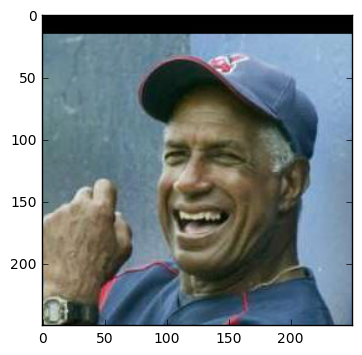

Transformed Image Size : (144, 144, 3)


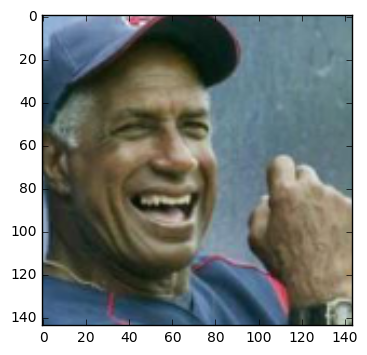

Original Image Size : 	 (250, 250, 3)


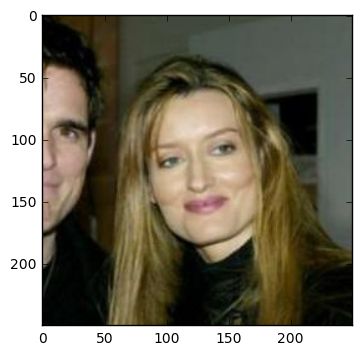

Transformed Image Size : (144, 144, 3)


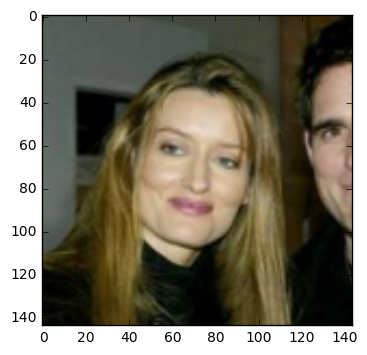

Original Image Size : 	 (250, 250, 3)


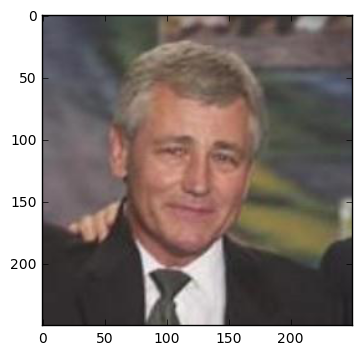

Transformed Image Size : (144, 144, 3)


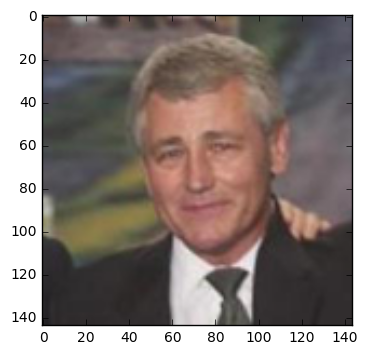

In [17]:
test_img_n = 3
random_img_list = np.random.randint(len(train_imgs), size=test_img_n)

for n in random_img_list:
    t_path = train_imgs[n]
    t_img = cv2.imread(t_path)
    print('Original Image Size : \t', t_img.shape)
    r, g, b = cv2.split(t_img)
    t_img = cv2.merge((b, g, r))
    plt.imshow(t_img)
    plt.show()

    t_img = transform_image(t_img)
    print('Transformed Image Size :', t_img.shape)
    plt.imshow(t_img)
    plt.show()

아래는 각 오려내서 추출한 이미지들을 한 묶음으로 넣기 위한 함수들 입니다.  
Train Set 과 Test Set의 함수가 다른 이유는  
Train Set은 Data Augmentation 을 위해 이미지 변화를 주었는데.  
Test 용 데이터는 변화를 주지 않고, 이미지 사이즈만 맞추어서  
모델이 Pred 하도록 하였습니다. 

In [18]:
def img2tensor(batch_path):
    for n, path in enumerate(batch_path):
        img = cv2.imread(path)
        r, g, b = cv2.split(img)
        img = cv2.merge((b, g, r))
        img = transform_image(img)

        if n == 0:
            batch_list = np.array([img])
        else:
            batch_list = np.concatenate((batch_list, [img]))

    return batch_list

In [19]:
def img2tensor_test(path):
    for n, path in enumerate(path):
        img = cv2.imread(path)
        r, g, b = cv2.split(img)
        img = cv2.merge((b, g, r))
        img = transform_test(img)

        if n == 0:
            batch_list = np.array([img])
        else:
            batch_list = np.concatenate((batch_list, [img]))
            
    return batch_list

# Optimization Setting

In [20]:
# Optimization Setting
global_step = tf.get_variable('global_step', [], 
                             initializer=tf.constant_initializer(0), trainable=False)

decay_steps = int(num_batches_per_epoch * num_epochs_per_decay)

# 위에 설정한 세팅대로 에폭마다 Learning Rate 이 줄어들도록 하였다. 
lr = tf.train.exponential_decay(initial_learning_rate, 
                               global_step,
                               decay_steps,
                               learning_rate_decay_factor,
                               staircase=True)



In [21]:
# 모델을 불러왔다.
model = VGG16()

In [22]:
logit = model.inference(x, keepratio)
loss = losses.binomial_cross_entropy_loss(labels=y, logits=logit)

optm = tf.train.AdamOptimizer(lr)
var_list = tf.trainable_variables()
grads_and_vars = optm.compute_gradients(loss, var_list=var_list)

# 이 부분을 돌리면 학습이 되는 것이다. 
train_op = optm.apply_gradients(grads_and_vars, global_step)

pred = tf.argmax(tf.nn.softmax(logit) ,1)
corr = tf.equal(pred, tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, tf.float32))
init = tf.global_variables_initializer()

In [23]:
# GPU 설정을 Full Setting으로 해놨다. 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Train Start

In [24]:
# Define Checkpoint
ckpt_dir = './checkpoint'
ckpt_name = 'project1'

Training Start
 [*] Reading checkpoint...
 [*] Load SUCCESS
Expect Total Time :  12:27:37.616100

Epoch: 0 -  0:02:29.525461
TrainSet - loss: 0.489562, accr: 0.734375
TestSet  - loss: 0.577980, accr: 0.703125

Epoch: 1 -  0:05:03.468879
TrainSet - loss: 0.620564, accr: 0.687500
TestSet  - loss: 0.684337, accr: 0.546875

Epoch: 2 -  0:07:33.528560
TrainSet - loss: 0.490371, accr: 0.765625
TestSet  - loss: 0.558492, accr: 0.687500

Epoch: 3 -  0:10:03.238306
TrainSet - loss: 0.475405, accr: 0.765625
TestSet  - loss: 0.539876, accr: 0.765625

Epoch: 4 -  0:12:32.846793
TrainSet - loss: 0.495951, accr: 0.765625
TestSet  - loss: 0.571518, accr: 0.718750

Epoch: 5 -  0:15:02.421550
TrainSet - loss: 0.383698, accr: 0.812500
TestSet  - loss: 0.819231, accr: 0.625000

Epoch: 6 -  0:17:32.270274
TrainSet - loss: 0.516891, accr: 0.750000
TestSet  - loss: 0.560418, accr: 0.703125

Epoch: 7 -  0:20:01.880681
TrainSet - loss: 0.340164, accr: 0.890625
TestSet  - loss: 0.447743, accr: 0.734375

Epoch:

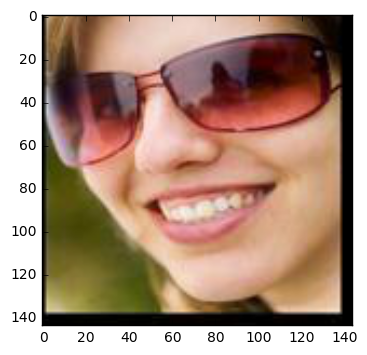

Predict Gender :  0


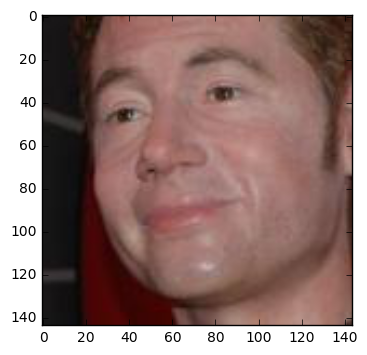

Predict Gender :  1


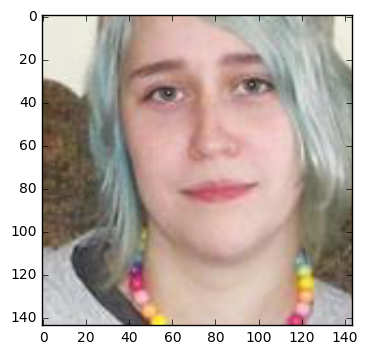

Predict Gender :  1


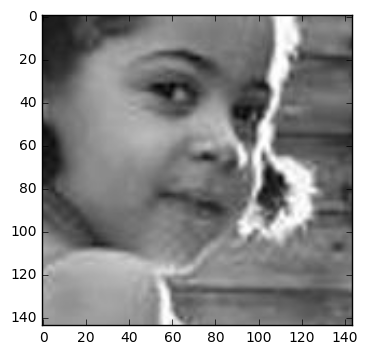

Predict Gender :  1


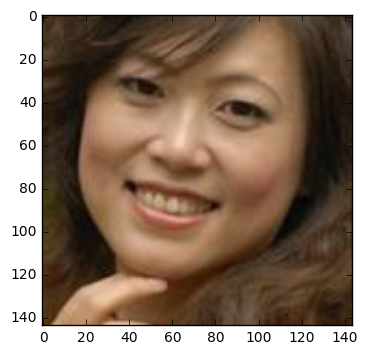

Predict Gender :  0


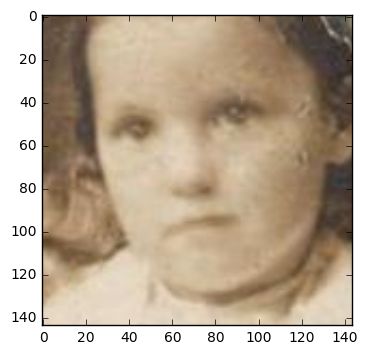

Predict Gender :  1


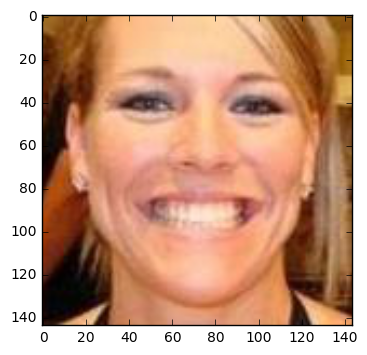

Predict Gender :  1


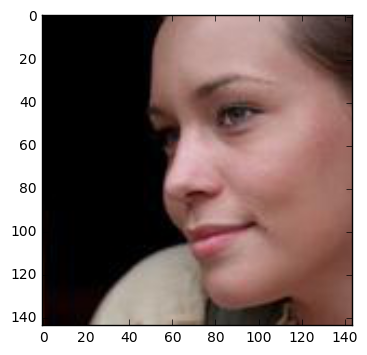

Predict Gender :  1


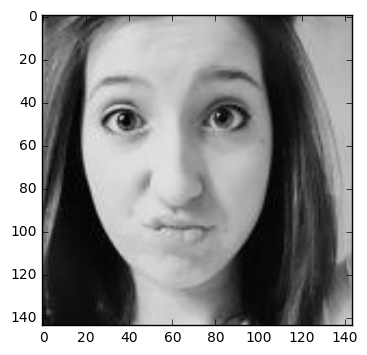

Predict Gender :  1


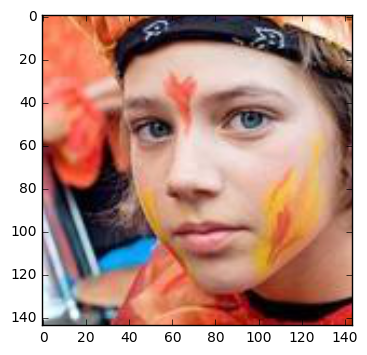

Training Finished at :  2017-04-14 08:20:23.801030


In [25]:
with tf.Session() as sess:
    sess.run(init)
    print("Training Start")
    start = datetime.now()

    # 저장한 Weight 값들이 있으면 불러오도록 했습니다. 
    ckpt_cnt = 1
    if utils.load_ckpt(ckpt_dir, sess, ckpt_name):
        print(" [*] Load SUCCESS")
    else:
        print(" [!] No Checkpoint to Load...")


    for epoch in range(total_epoch):
        idx_orders = list(range(len(train_imgs)))
        shuffle(idx_orders)                        # 불러올 이미지 목록들을 먼저 순서대로 가져온 후 섞도록 하였습니다. 

        for step in range(num_batches_per_epoch):  # 앞에 계산했던 epoch 마다 돌아갈 batch 수 만큼 iteration을 했습니다. 
            batch_idx = idx_orders[step * batch_size:(step+1) * batch_size]
            batch_img_path = np.array(train_imgs)[batch_idx]

            batch_imgs = img2tensor(batch_img_path) # 앞에 만들었던 함수로 불러온 이미지 목록들을 tensor로 변환 시켜 줍니다. 
            batch_labels = np.array(train_labels)[batch_idx]

            feed_train = {x: batch_imgs, y:batch_labels, keepratio:0.7}
            feed_train_full = {x: batch_imgs, y:batch_labels, keepratio:1.}
            sess.run(train_op, feed_train)

        if epoch == 0:
            print('Expect Total Time : ', total_epoch*(datetime.now()-start))
        
        print('\nEpoch: %d - ' % (epoch), datetime.now() - start)
        print('TrainSet - loss: %f, accr: %f' % 
              (sess.run(loss, feed_train_full), sess.run(accr, feed_train_full)))

        
        # For Test Validation
        # 앞 부분들은 Optimization 학습을 위한 것이고, 아래 부터는 학습한 모델로 테스트 하기 위합니다. 
        test_idx_orders = list(range(len(test_imgs)))
        shuffle(test_idx_orders)

        test_idx = test_idx_orders[:batch_size]
        batch_test_path = np.array(test_imgs)[test_idx]

        batch_test_images = img2tensor_test(batch_test_path)
        batch_test_labels = np.array(test_labels)[test_idx]
        
        feed_test = {x: batch_test_images, y:batch_test_labels, keepratio:1.}
        sess.run(train_op, feed_test)

        print('TestSet  - loss: %f, accr: %f' % (sess.run(loss, feed_test), sess.run(accr, feed_test)))

        # 학습하고 나면 하나씩 그 모델을 저장하도록 하였습니다. 
        ckpt_cnt += 1
        if np.mod(ckpt_cnt, 100) == 1:
            pass
        if np.mod(ckpt_cnt, 1000) == 2:
            utils.save_ckpt(ckpt_dir, ckpt_cnt, sess, ckpt_name)
                
    test_idx_orders = list(range(len(test_imgs)))
    shuffle(test_idx_orders)

    test_idx = test_idx_orders[:batch_size]
    batch_test_path = np.array(test_imgs)[test_idx]

    batch_test_images = img2tensor_test(batch_test_path)
    batch_test_labels = np.array(test_labels)[test_idx]

    feed_test = {x: batch_test_images, y:batch_test_labels, keepratio:1.}
    
    for idx in range(10):
        pred_gender = sess.run(pred, feed_test)
        print('Predict Gender : ', pred_gender[idx])
        
        plt.imshow(batch_test_images[idx])
        plt.show()
        
        time.sleep(2)


print('Training Finished at : ', datetime.now())